### On the first run, you must install the causal-impact package

In [523]:
# uncomment below and install on the very first run

# import sys
# !{sys.executable} -m pip install pycausalimpact

# Libraries 

In [1]:
# These are libraries we're going to need every time we run

import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)
from datetime import datetime
from dateutil.parser import parse
from IPython.display import FileLink, FileLinks

from causalimpact import CausalImpact

citing = 'CausalImpact 1.2.1, Brodersen et al., Annals of Applied Statistics (2015). http://google.github.io/CausalImpact/'
citingPython = 'https://github.com/dafiti/causalimpact'

# Modify the cell below (follow comments)

### side note: the input file should be structured:

|           Date          |                 Past data                |          Current data         |
|:-----------------------:|:----------------------------------------:|:-----------------------------:|
|         YYYY-MM-DD        |             aka, the Control             |       aka, the Treatment      |
| (list as current dates) | (what we're using to id' trends in data) | (when change was implemented) |
|         2019-01-01        |                  9493.21                 |            10546.02           |
|   data type = datetime  |         data type = float or int         |    data type = float or int   |
|   variable name = date  |             variable name = x            |       variable name = y       |

In [12]:
# give the test a name to appear as chart title (can be anything, spaces can be included)
test_name = 'Test Data Report'

# add the name of the variable/metric that was tested (what are we evaluating?)
metric = 'Test'

# add the .csv file name, the notebook must be in the same folder
input_filename = 'https://raw.githubusercontent.com/als429/blah-blah/master/data.csv' # must be a .csv

# FOR MERKLE TEAM:
# https://raw.githubusercontent.com/als429/blah-blah/master/bSess.csv - 3/25/19 (no impact)
# https://raw.githubusercontent.com/als429/blah-blah/master/oSess.csv - 5/1/19 and 5/15/19 (both up)
# https://raw.githubusercontent.com/als429/blah-blah/master/xml-data.csv - 2/4/19 (up)
# https://raw.githubusercontent.com/als429/blah-blah/master/tCh.csv - 1/21/19 (no impact, ci.plot() not working)
# https://raw.githubusercontent.com/als429/blah-blah/master/rCh.csv - 1/21/19 (no impact, ci.plot() not working)
# https://raw.githubusercontent.com/als429/blah-blah/master/data.csv - 5/6/19 (up, ci.plot() not working)

# implementation date (When was the test implemented?), also called the "post-start" date
implementation_month = '05'
implementation_day = '06'
implementation_year = '2019'
implementation_date =  implementation_year + '-' + implementation_month + '-' + implementation_day

# add the name of the file for your excel output (leave the .csv)
output_filename = 'change filename here' + '.csv'

# get data

In [3]:
# read the csv data
# may need to uncomment and comment (adding # in front of), if data is separated differently

# use if data is space separated
# data = pd.read_csv(input_filename,sep=' ', index_col='Date') 

# use if data is tab separated
# data = pd.read_csv(input_filename,sep='\t', index_col='Date') 

# use if data is comma separated
data = pd.read_csv(input_filename,sep=',', index_col='Date') 

In [4]:
# print this to ensure that data is coming in properly
# it should look like a table with your data pulling in

data.head()

,2018,2019
Date,,
2019-03-01,105,187
2019-03-02,99,260
2019-03-03,180,265
2019-03-04,218,253
2019-03-05,160,190


In [5]:
# rename column headings for causal-impact library
# date -- x --- y

data.columns = ['x0','y']

# data.columns = ['y', 'x0', 'x1']

data = data[['y','x0']] # switches the column ordering

# printing end of the data
data.head()

,y,x0
Date,,
2019-03-01,187,105
2019-03-02,260,99
2019-03-03,265,180
2019-03-04,253,218
2019-03-05,190,160


### May need to modify the data to get the appropriate types

* remember we want - datetime, float/int, float/int

|           Date          |                 Past data                |          Current data         |
|:-----------------------:|:----------------------------------------:|:-----------------------------:|
|   data type = datetime  |         data type = float or int         |    data type = float or int   |

In [6]:
# this shows you the date types (int, float, object) of each section
# you may need to modify
data.dtypes

y     int64
x0    int64
dtype: object

In [7]:
# may need this cell, if data is pulling in as strings (i.e., object)

# # remove any dollar signs and commas from x (past data, control) and update to a float
# data['x'] = data['x'].str.replace("$","")
# data['x'] = data['x'].str.replace(",","")
# data['x'] = data['x'].astype(float)

# # remove any dollar signs and commas from y (current data, treatment) and update to a float
# data['y'] = data['y'].str.replace("$","")
# data['y'] = data['y'].str.replace(",","")
# data['y'] = data['y'].astype(float)

In [8]:
# drop any data will null values
data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# print the number of nulls, should be zero for each column listed
data.isnull().sum(axis = 0)

y     0
x0    0
dtype: int64

## Trended data
* This is to ensure that everything looks right to make sure we have a gut check

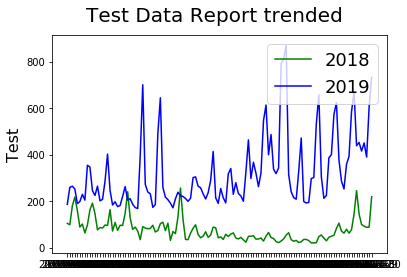

In [9]:
# plot past and current data
fig, ax = plt.subplots()

# labels for the trended plot
title = test_name + ' trended'
plt.ylabel(metric, fontsize=16)
##plt.xlabel('date', fontsize=18)
fig.suptitle(title, fontsize=20)

# trended line data + legend
past = data['x0']
current = data['y']

# plotting the graph
ax.plot(past, 'g-')
ax.plot(current, 'b-')


# adding the legend (assumes Year over Year)
ax.legend([int(implementation_year) - 1, implementation_year], loc='upper right', fontsize=18)

In [10]:
data.head()

,y,x0
Date,,
2019-03-01,187,105
2019-03-02,260,99
2019-03-03,265,180
2019-03-04,253,218
2019-03-05,190,160


In [13]:
implementation_date

'2019-05-06'

In [14]:
pre_period = [np.min(data.index.values), implementation_date]
post_period = ["2019-05-07", np.max(data.index.values)] # will need to update this date to a date following the implementation_date

In [15]:
pre_period

['2019-03-01', '2019-05-06']

In [16]:
post_period

['2019-05-07', '2019-06-30']

In [17]:
ci = CausalImpact(data.iloc[:, 0], pre_period, post_period, nseasons=[{'period': 52}])

C:\Users\asanders\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\asanders\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\structural.py:1788: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)
C:\Users\asanders\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [18]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    402.2              22123.0
Prediction (s.d.)         260.6 (13.0)       14335.4 (714.8)
95% CI                    [235.5, 286.5]     [12954.8, 15756.9]

Absolute effect (s.d.)    141.6 (13.0)       7787.6 (714.8)
95% CI                    [115.7, 166.7]     [6366.1, 9168.2]

Relative effect (s.d.)    54.3% (5.0%)       54.3% (5.0%)
95% CI                    [44.4%, 64.0%]     [44.4%, 64.0%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


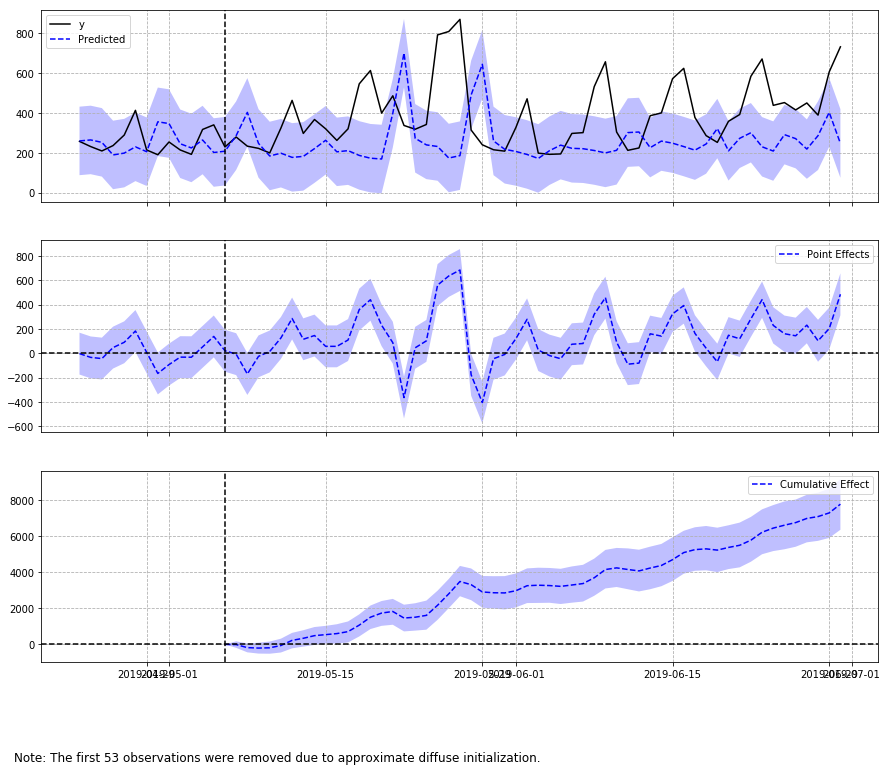

In [19]:
ci.plot()

In [20]:
ci.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
2019-03-01,NaN,255.567164,NaN,NaN,NaN,-986956.835692,987467.970020,NaN,NaN,NaN,-68.567164,-987280.970020,987143.835692,NaN,NaN,NaN
2019-03-02,NaN,255.567164,NaN,NaN,NaN,-986956.835693,987467.970021,NaN,NaN,NaN,4.432836,-987207.970021,987216.835693,NaN,NaN,NaN
2019-03-03,NaN,253.027640,NaN,NaN,NaN,-986282.042465,986788.097744,NaN,NaN,NaN,11.972360,-986523.097744,986547.042465,NaN,NaN,NaN
2019-03-04,NaN,255.731343,NaN,NaN,NaN,-986279.338762,986790.801449,NaN,NaN,NaN,-2.731343,-986537.801449,986532.338762,NaN,NaN,NaN
2019-03-05,NaN,253.455224,NaN,NaN,NaN,-985652.246371,986159.156819,NaN,NaN,NaN,-63.455224,-985969.156819,985842.246371,NaN,NaN,NaN


In [21]:
ci.trained_model.params

sigma2.irregular               4.083826e-01
sigma2.level                   6.944444e-05
sigma2.freq_seasonal_52(26)    1.910816e-11
dtype: float64

# results summary

In [632]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 9782.6. By contrast, in the absence of an
intervention, we would have expected an average response of 6783.5.
The 95% interval of this counterfactual prediction is [6301.4, 7294.8].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2999.1 with a 95% interval of
[2487.8, 3481.2]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 831519.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 576599.5. The 95% interval of this prediction is [535616.3, 620059.3].


The above results are given in terms of absolute numbers. In relative
terms, the 

# output the files

In [371]:
# output trended .png
fig.savefig(test_name +' trended.png')

# adds a link to the local file, run cell and click below
FileLink(test_name +' trended.png')

C:\Users\asanders\Test Data Report trended.png

In [381]:
# output CausalImpact .png
ci.savefig('test.png')

## TO DO: ci isn't a typical plot...  :-(

AttributeError: 'CausalImpact' object has no attribute 'savefig'

In [203]:
# output .csv file
ci.inferences.to_csv(output_filename, sep=',')

# adds a link to the local file, run cell and click below
FileLink(output_filename)

C:\Users\asanders\change filename here.csv

# references
* CausalImpact 1.2.1, Brodersen et al., Annals of Applied Statistics (2015). http://google.github.io/CausalImpact/
* Python library: https://github.com/dafiti/causalimpact
* Inspired by https://twitter.com/johncaiozzo's R script